# Beispiel California-Hauspreise
------------------------------------------------

## Notwendige Bibliotheken laden

* pandas für Verarbeitung von Tabellen-Daten
* numpy für die Berechnung von Zusammenhängen (z.B. Korrelationen)
* missingno für die Visualisierung von fehlenden Datenpunkten
* matplotlib, seaborn, plotly für die Visualisierung
* sklearn für ML-Algorithmen


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import missingno
import plotly.express as px

from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split # Datensplits
from sklearn.linear_model import LinearRegression # Machine Learning
from sklearn import metrics # Modellevaluierung

from scipy import stats
import warnings
warnings.simplefilter("ignore")

## Daten einlesen und Überblick verschaffen (simple Metadaten)


In [218]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Datensatz housing.csv - Metadaten*
---------------------------------------------------

This dataset is a modified version of the California Housing dataset available from Luís Torgo's page (University of Porto). Luís Torgo obtained it from the StatLib repository (which is closed now). The dataset may also be downloaded from StatLib mirrors.
This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

The current version of this dataset is taken from: https://github.com/ageron/handson-ml/tree/master/datasets/housing

In [219]:
df.shape

(20640, 10)

In [220]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

## Fehlende Werte
finden und entfernen

In [221]:
for col in df.columns:
    pct_missing = df[col].isnull().sum()
    print(f'{col} - {pct_missing :}')

longitude - 0
latitude - 0
housing_median_age - 0
total_rooms - 0
total_bedrooms - 207
population - 0
households - 0
median_income - 0
median_house_value - 0
ocean_proximity - 0


In [222]:
df = df.dropna() # löscht alle Zeilen mit fehlenden Attributen
df = df.reset_index(drop=True) # zählt unsere Daten neu durch

## Duplikate
finden und entfernen

In [223]:
df.duplicated().sum()

0

## Statistik Übersicht

In [224]:
description = df.describe()
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


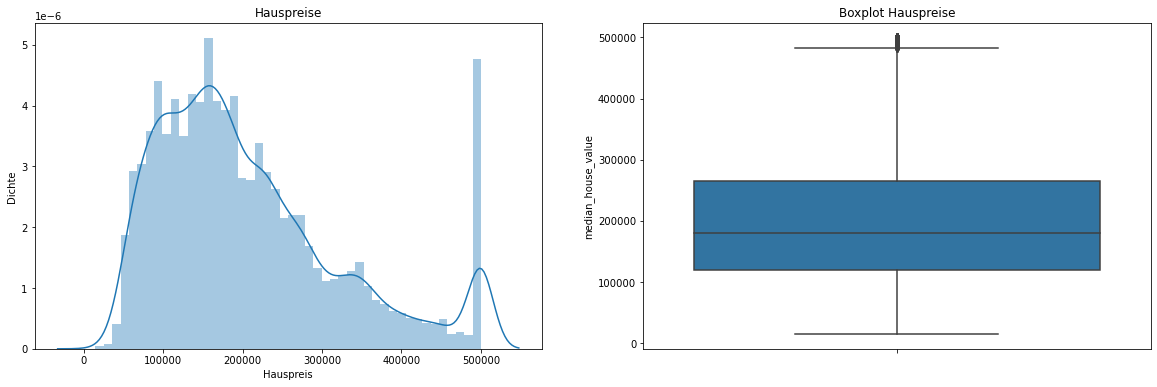

In [225]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Hauspreise')
sns.distplot(df['median_house_value'])
plt.xlabel('Hauspreis')
plt.ylabel('Dichte')

plt.subplot(1,2,2)
plt.title('Boxplot Hauspreise')
sns.boxplot(y=df['median_house_value'])

plt.show()

In [226]:
category = df['ocean_proximity'].unique()
print("Kategorien in Experience Level: ", category)

Kategorien in Experience Level:  ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


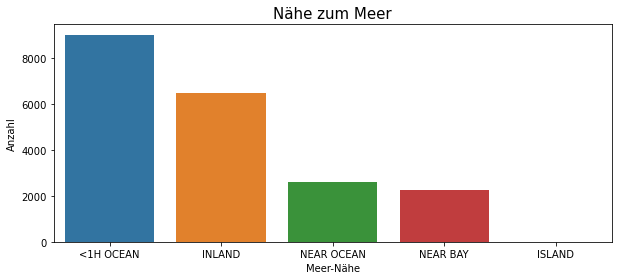

In [227]:
# Balkendiagramm mit seaborn countplot
plt.figure(figsize=(10,4))
sns.countplot(data = df, x = 'ocean_proximity', order = df['ocean_proximity'].value_counts().index)
plt.title("Nähe zum Meer",fontsize=15)
plt.xlabel("Meer-Nähe",fontsize=10)
plt.ylabel("Anzahl",fontsize=10)
plt.show()

## Kategorisieren der Daten

* Einsortierung der Hauspreise in Kategorien nach Quantilen
* Ziel: Trainings- und Testdaten erhalten gleiche (oder zumindest möglichst ähnliche) Verteilung der Zielvariable median_house_value

In [228]:
bins = [0] + list(description["median_house_value"][
    ["25%", "50%", "75%"]
].astype(int)) + [np.inf]
print(bins) # 0 bis 119.500 = 0 - 25% Quantil, 119.500 bis 179.700 = 25 - 50% Quantil, ...

[0, 119500, 179700, 264700, inf]


In [229]:
df["house_cat"] = pd.cut(
    df["median_house_value"],
    bins=bins, labels=["0 - 25%", "25 - 50%", "50 - 75%", "75 - 100%"])

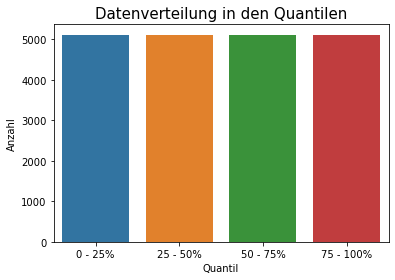

In [230]:
sns.countplot(data=df, x="house_cat")
plt.title("Datenverteilung in den Quantilen",fontsize=15)
plt.xlabel("Quantil",fontsize=10)
plt.ylabel("Anzahl",fontsize=10)
plt.show()

## Splitten in Trainings- und Testdatensatz

In [268]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=6)
for train_index, test_index in split.split(df, df["house_cat"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

<Axes: xlabel='house_cat', ylabel='count'>

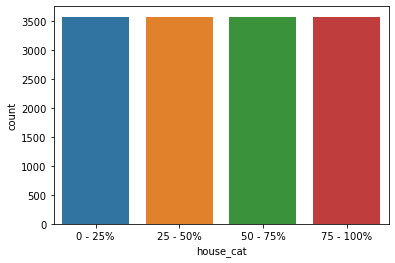

In [269]:
# Verteilung im Trainingsdatensatz
sns.countplot(data=df_train, x="house_cat")

<Axes: xlabel='house_cat', ylabel='count'>

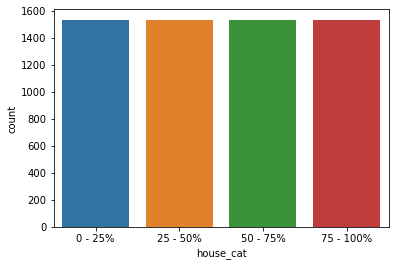

In [270]:
# Verteilung im Testdatensatz
sns.countplot(data=df_test, x="house_cat")

In [271]:
# Löschen der Hilfsvariable 'house_cat' aus den gesplitteten Datensätzen
df_train = df_train.drop("house_cat", axis=1)
df_test = df_test.drop("house_cat", axis=1)

# Löschen der Hasupreise > 500k
#df_train = df_train[(df_train['median_house_value'] <=499999)]
#df_test = df_test[(df_test['median_house_value'] <=499999)]

## Darstellung der Daten in einer Karte - auch das geht mit Python!

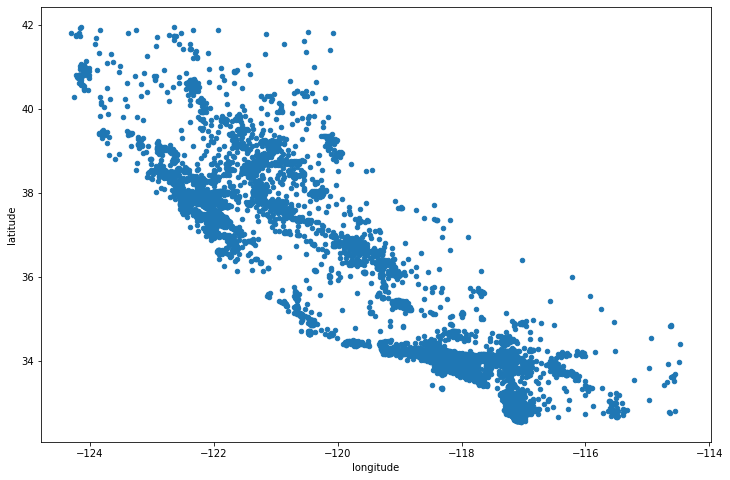

In [272]:
# Simpler Scatterplot zur Verteilung - wo haben wir Daten
df_train.plot(kind="scatter", x="longitude", y="latitude", figsize=(12, 8));

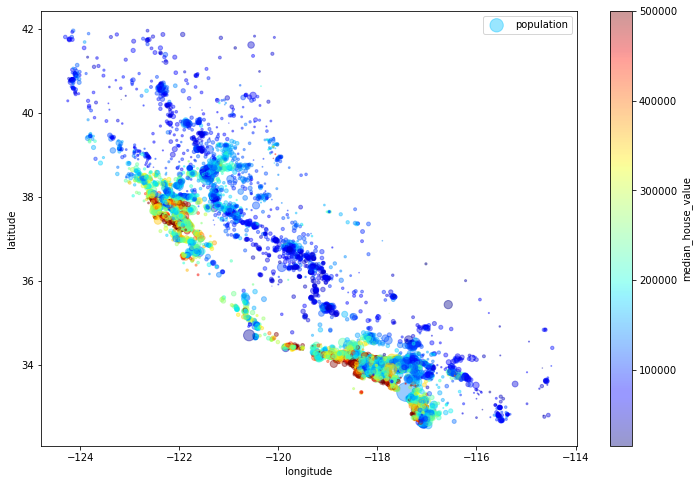

In [273]:
# Schon etwas mehr Info - wir nehmen die Hauspreise zur Farbcodierung
df_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
    s=df_train["population"]/100, label="population", figsize=(12, 8), c="median_house_value", 
    cmap=plt.get_cmap("jet"), colorbar=True, sharex=False
)
plt.legend();

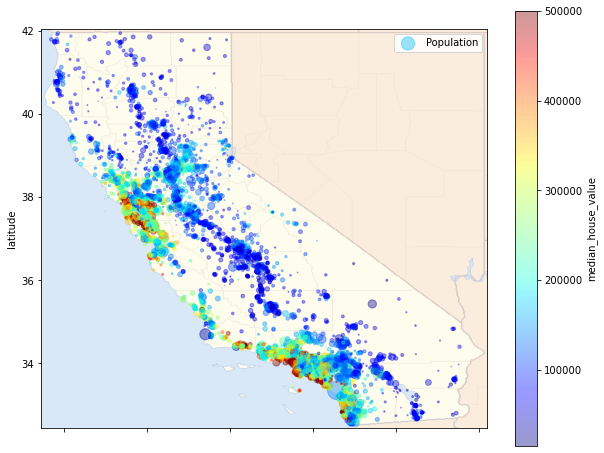

In [274]:
# Funktion für Darstellung auf einer Karte
def plot_df_on_california(df, california_path):

    ax = df.plot(
        kind="scatter", 
        x="longitude", 
        y="latitude", 
        figsize=(10, 8),
        s=df['population']/100, 
        label="Population",
        c="median_house_value", 
        cmap=plt.get_cmap("jet"),
        colorbar=True, 
        alpha=0.4
    )

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    california_img = mpimg.imread(california_path)
    plt.imshow(
        california_img, 
        extent=[-124.55, -113.8, 32.45, 42.05], 
        alpha=0.4,
        cmap=plt.get_cmap("jet")
    )

    plt.legend();


CALIFORNIA_PATH = "california.png"

plot_df_on_california(df_train, CALIFORNIA_PATH)

Wir sehen ganz deutlich:

* an der Küste sind die Preise höher, im Inland sind die Preise wesentlich geringer
* teure Wohngebiete treten selten alleine auf, sondern gruppieren sich


In [275]:
median_house_values_by_proximity = df_train.groupby("ocean_proximity")["median_house_value"].median()
median_house_values_by_proximity

ocean_proximity
<1H OCEAN     215600.0
INLAND        108950.0
ISLAND        414700.0
NEAR BAY      233100.0
NEAR OCEAN    226250.0
Name: median_house_value, dtype: float64

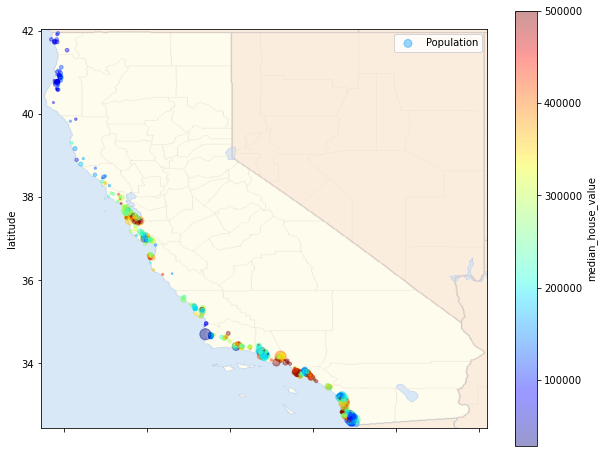

In [276]:
# Ansicht der Lage je nach Kategorie - Meernähe

def filter_df_by_proximity(df, proximity):
    return df.loc[df["ocean_proximity"] == proximity]

plot_df_on_california(filter_df_by_proximity(df_train, "NEAR OCEAN"), CALIFORNIA_PATH)

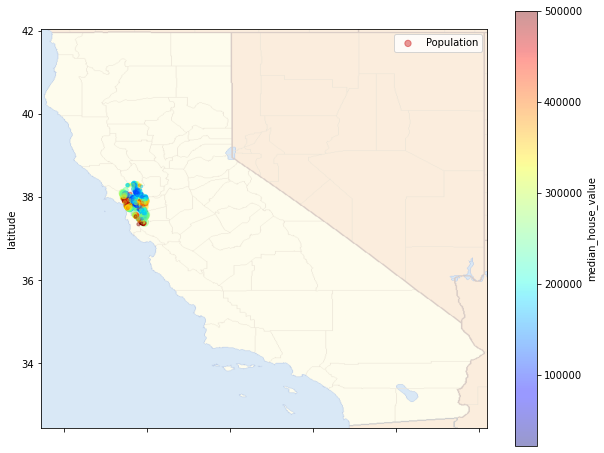

In [277]:
# Gegend um San Francisco
plot_df_on_california(filter_df_by_proximity(df_train, "NEAR BAY"), CALIFORNIA_PATH)

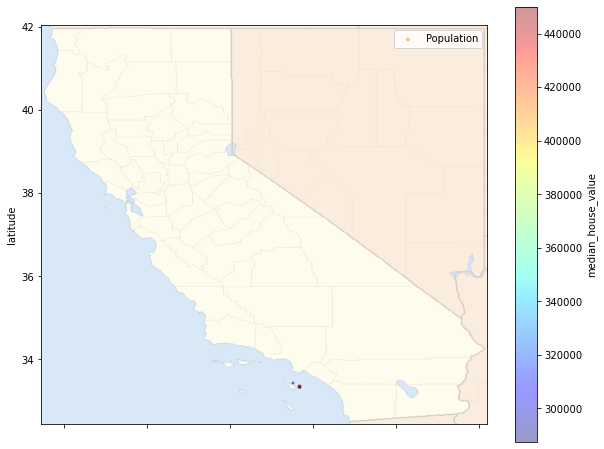

In [278]:
# Island
plot_df_on_california(filter_df_by_proximity(df_train, "ISLAND"), CALIFORNIA_PATH)

Für Island gibt es zuwenig Werte, als das wir das als Kategorie tatsächlich betrachten sollten. Wir löschen es aus dem Datensatz.

In [279]:
df_train = df_train.drop(filter_df_by_proximity(df_train, "ISLAND").index)
df_test = df_test.drop(filter_df_by_proximity(df_test, "ISLAND").index)

## Übersicht über Zusammenhänge in den Daten (Beispiel Testdaten als kleinerer Teildatensatz)

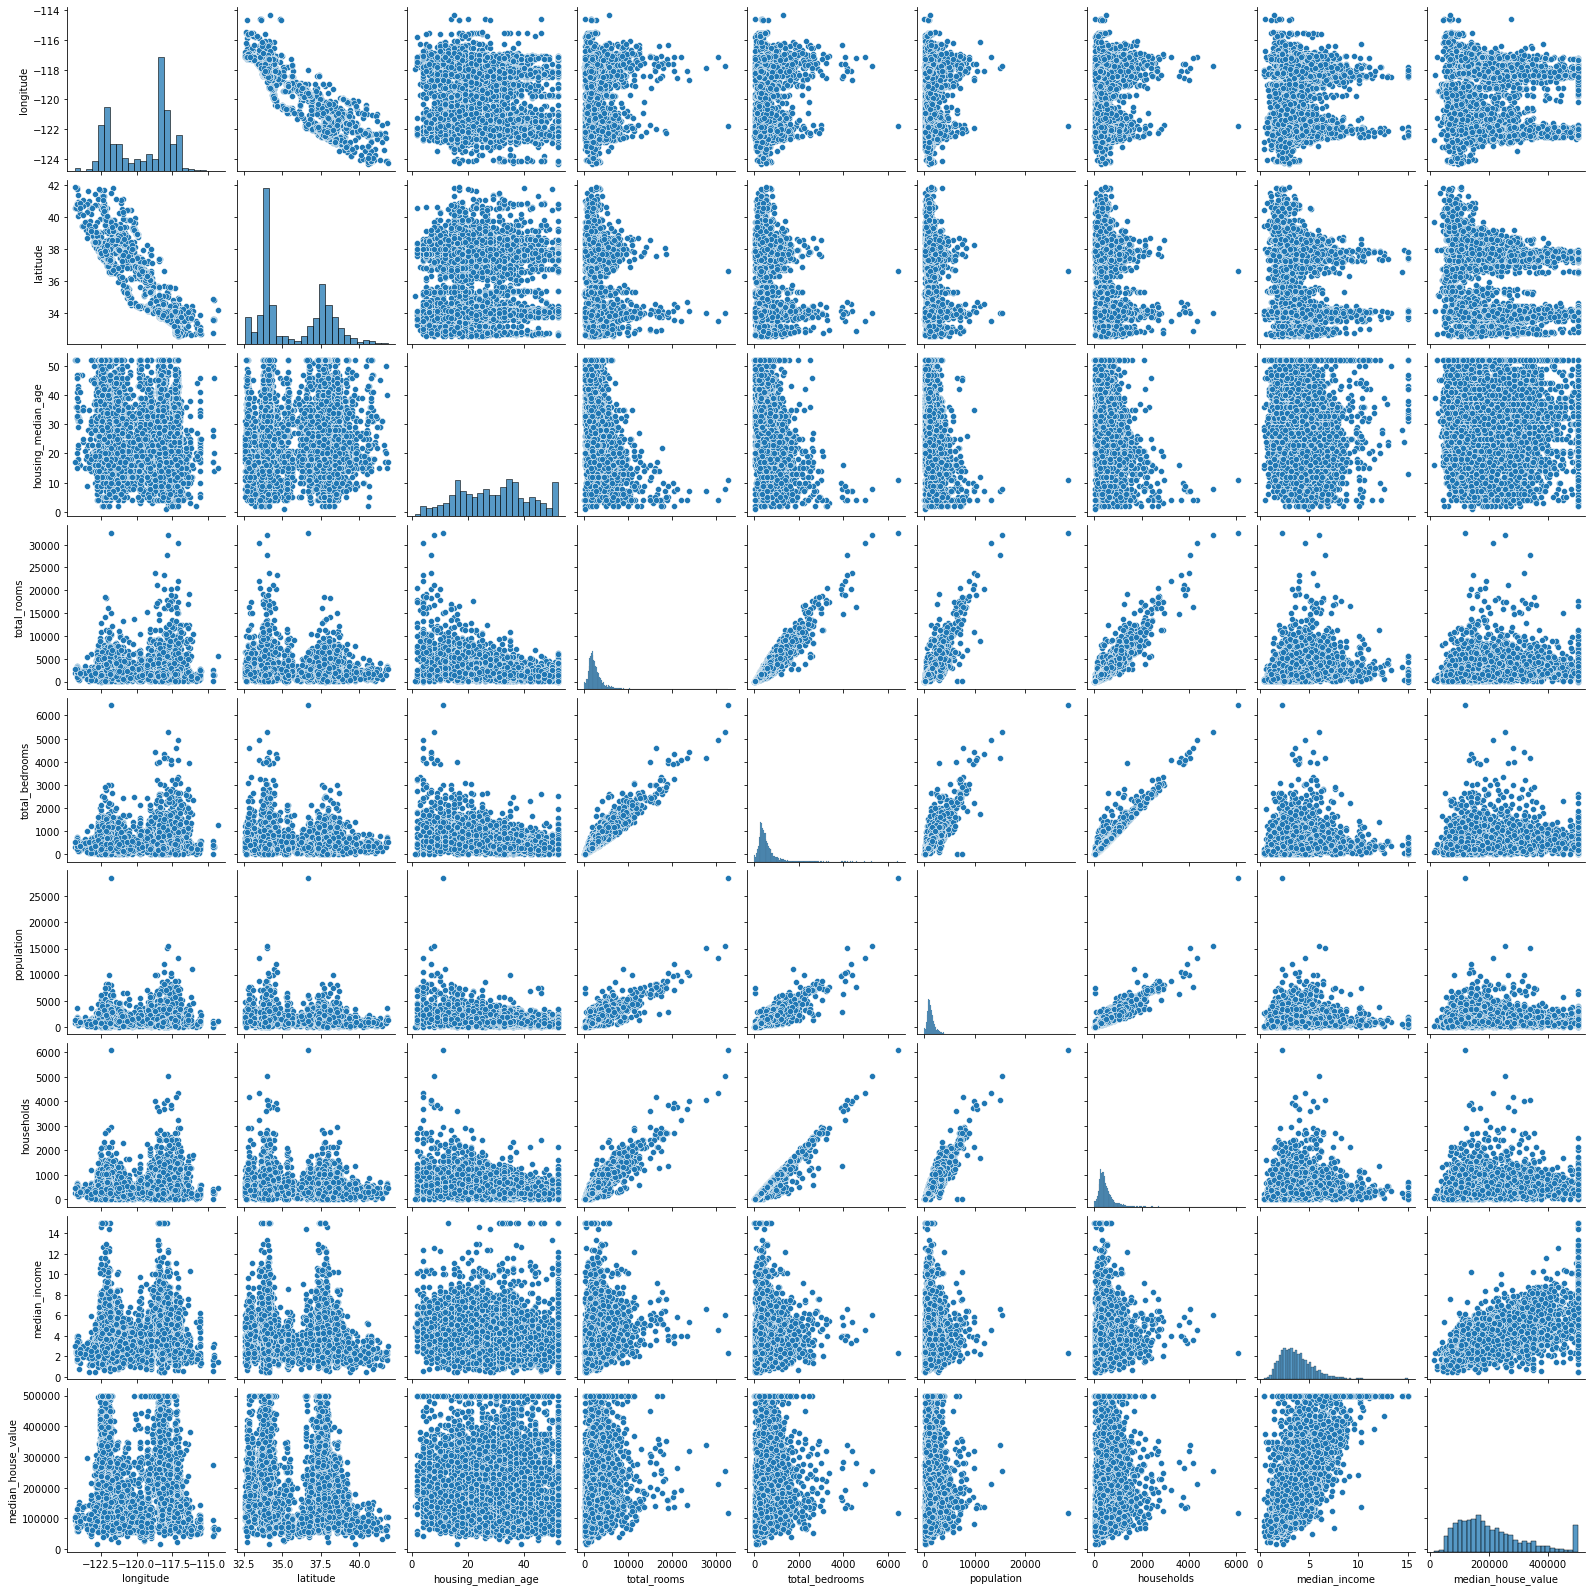

In [280]:
sns.pairplot(df_test)
plt.show()

## Zusammenfassung von Variablen zu einer neuen Variable (weil Abhängigkeiten bestehen) 

In [281]:
def engineer_features(df):
    df["ratio_bedrooms"] = df["total_bedrooms"] / df["total_rooms"]
    df["people_per_household"] = df["population"] / df["households"]
    return df

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

df_train.corr()["median_house_value"].abs().sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687312
ratio_bedrooms          0.251899
latitude                0.151763
total_rooms             0.139745
housing_median_age      0.105680
households              0.071399
total_bedrooms          0.057065
people_per_household    0.047904
longitude               0.038773
population              0.021620
Name: median_house_value, dtype: float64

# Starten der ML-Analyse

In [282]:
# Dummy-Variable für Kategorie 'ocean_proximity' - Umwandeln in numerische werte
# Pandas liefert uns hier eine One-Hot Transformation.

df_train_ml = pd.get_dummies(df_train)
df_test_ml = pd.get_dummies(df_test)

df_train_ml.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ratio_bedrooms,people_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14908,-116.83,32.83,6.0,3123.0,495.0,1513.0,480.0,5.4288,167800.0,0.158501,3.152083,1,0,0,0
5920,-117.75,34.10,21.0,8069.0,2174.0,4369.0,2036.0,3.2756,156800.0,0.269426,2.145874,0,1,0,0
11906,-117.50,33.95,29.0,932.0,153.0,711.0,172.0,4.8214,143400.0,0.164163,4.133721,0,1,0,0
7271,-118.15,33.96,33.0,1201.0,340.0,1482.0,334.0,2.4821,150000.0,0.283097,4.437126,1,0,0,0
5040,-118.30,33.97,46.0,1425.0,317.0,1140.0,304.0,3.3750,98500.0,0.222456,3.750000,1,0,0,0


In [283]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#num_vars = ['median_house_value', 'median_income', 'longitude', 'latitude']
#df_train_ml[num_vars] = scaler.fit_transform(df_train_ml[num_vars])
#df_test_ml[num_vars] = scaler.fit_transform(df_test_ml[num_vars])
#df_train_ml.head()

## Festlegen der unabhängigen und abhängigen Variablen

In [284]:
y_train = df_train_ml.pop('median_house_value')
X_train = df_train_ml

y_test = df_test_ml.pop('median_house_value')
X_test = df_test_ml

In [285]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [286]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)
X_train.columns[rfe.support_]

Index(['longitude', 'latitude', 'median_income', 'ratio_bedrooms',
       'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [287]:
#function Modellbildung
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X

#function Prüfen des variance inflation factors (zeigt Kolinearität)
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [288]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,longitude,latitude,median_income,ratio_bedrooms,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14908,-116.83,32.83,5.4288,0.158501,0,0,0
5920,-117.75,34.10,3.2756,0.269426,1,0,0
11906,-117.50,33.95,4.8214,0.164163,1,0,0
7271,-118.15,33.96,2.4821,0.283097,0,0,0
5040,-118.30,33.97,3.3750,0.222456,0,0,0


In [289]:
X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     3201.
Date:                Thu, 14 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:41:48   Log-Likelihood:            -1.8020e+05
No. Observations:               14298   AIC:                         3.604e+05
Df Residuals:                   14290   BIC:                         3.605e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [290]:
checkVIF(X_train_new)

,Features,VIF
0,const,31674.20
2,latitude,18.78
1,longitude,16.83
5,ocean_proximity_INLAND,2.88
3,median_income,1.98
4,ratio_bedrooms,1.88
6,ocean_proximity_NEAR BAY,1.50
7,ocean_proximity_NEAR OCEAN,1.18


In [291]:
X_train_new = X_train_new.drop(["latitude"], axis = 1)
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     3575.
Date:                Thu, 14 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:41:50   Log-Likelihood:            -1.8039e+05
No. Observations:               14298   AIC:                         3.608e+05
Df Residuals:                   14291   BIC:                         3.609e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [292]:
checkVIF(X_train_new)

,Features,VIF
0,const,4960.87
2,median_income,1.95
3,ratio_bedrooms,1.88
5,ocean_proximity_NEAR BAY,1.49
4,ocean_proximity_INLAND,1.46
1,longitude,1.36
6,ocean_proximity_NEAR OCEAN,1.14


Text(0.5, 0, 'Errors')

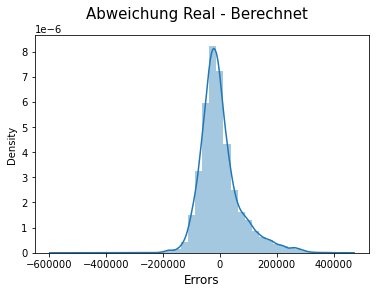

In [293]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train_pred = lm.predict(X_train_new)

fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 40)
fig.suptitle('Abweichung Real - Berechnet', fontsize = 15)                  # Plot heading
plt.xlabel('Errors', fontsize = 12)

# Modell anwenden

In [294]:
# Neuer Testdatensatz (weglassen der überflüssigen Spalten)
X_train_new = X_train_new.drop('const',axis=1)
#X_train_new.head()
X_test_new = X_test[X_train_new.columns]
# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

# Vorhersagen für y berechnen
y_pred = lm.predict(X_test_new)



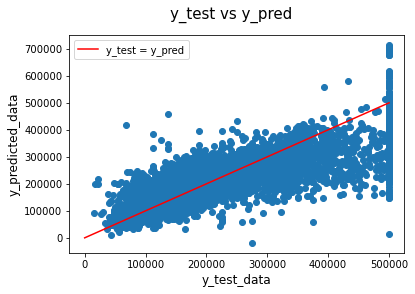

In [295]:
#Modell evaluieren
# Plotte y_test und y_pred in ein Streudiagramm
def linear_function(x):
    return 1* x

x_range = np.linspace(0, 500000, 10)
y_function = linear_function(x_range)

fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=15)
plt.xlabel('y_test_data', fontsize=12)
plt.ylabel('y_predicted_data', fontsize=12)
plt.plot(x_range, y_function, label='y_test = y_pred', color='red')
plt.legend()
plt.show()

Text(0.5, 0, 'Errors')

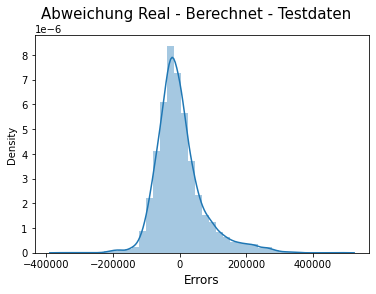

In [296]:
fig = plt.figure()
sns.distplot((y_test - y_pred), bins = 40)
fig.suptitle('Abweichung Real - Berechnet - Testdaten', fontsize = 15)                  # Plot heading
plt.xlabel('Errors', fontsize = 12)

In [297]:
# Metriken berechnen
mae = metrics.mean_absolute_error(y_test, y_pred)
mae_ratio = metrics.mean_absolute_percentage_error(y_test, y_pred)
r2_score = metrics.r2_score(y_test, y_pred)

print(f"Wir können durchschnittlich mit einem Fehler von {np.round(mae)} USD rechnen;")
print(f"Das entspricht im Schnitt einer Fehlerquote von {np.round(mae_ratio * 100)}%;")
print(f"Der R^2 Werte liegt bei {np.round(r2_score * 100)}%")

Wir können durchschnittlich mit einem Fehler von 52001.0 USD rechnen;
Das entspricht im Schnitt einer Fehlerquote von 29.0%;
Der R^2 Werte liegt bei 61.0%


In [298]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     3575.
Date:                Thu, 14 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:42:06   Log-Likelihood:            -1.8039e+05
No. Observations:               14298   AIC:                         3.608e+05
Df Residuals:                   14291   BIC:                         3.609e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

# Zusammenfassung

Modell erklärt Hauspreise mit einer Fehlerrate von 29%. Fehler entsteht durch das Abschneiden der Daten bei 500k USD - alle Preis größer diesem Wert werden auf dieses Maximum gesetzt. 

- eventuell: Werte > 499k abschneiden (df1 = df[(df['median_house_value'] <=499999)])
- Frage: Linearer Zusammenhang?